In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
scaler = StandardScaler()
data = pd.read_csv('data_round2.csv')
def leave_one_out_validation(best_model, scaler, X_model, y):
    """
    Perform leave-one-out validation.

    Parameters:
    best_model (object): The trained best model.
    scaler (object): The standardization scaler.
    X_model (DataFrame): The feature data.
    y (Series): The target data.

    Returns:
    r2_loo (float): The R^2 score from leave-one-out validation.
    """
    loo = LeaveOneOut()
    y_pred_loo = []
    y_true_loo = []
    for train_index, test_index in loo.split(X_model):
        X_train_loo, X_test_loo = X_model.iloc[train_index], X_model.iloc[test_index]
        y_train_loo, y_test_loo = y.iloc[train_index], y.iloc[test_index]
        best_model.fit(scaler.fit_transform(X_train_loo), y_train_loo)
        y_pred_loo.append(best_model.predict(scaler.transform(X_test_loo))[0])
        y_true_loo.append(y_test_loo.values[0])
    r2_loo = r2_score(y_true_loo, y_pred_loo)
    return r2_loo
def plot_model_results(data, model,random_state=42):
    features = data.select_dtypes(include=[np.number]).columns
    X = data[features].drop('yield', axis=1)
    y = data['yield']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    model.fit(scaler.fit_transform(X_train), y_train)
    y_pred_train = model.predict(scaler.transform(X_train))
    y_pred_test = model.predict(scaler.transform(X_test))
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_LOO = leave_one_out_validation(model, scaler, X, y)

    r2_test_list = []
    mae_test_list = []
    model1 = model
    for i in range(100):
        random_state = i
        X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=random_state)
        model1.fit(scaler.fit_transform(X_train_1), y_train_1)
        y_pred_test_1 = model1.predict(scaler.transform(X_test_1))
        r2_test_1 = r2_score(y_test_1, y_pred_test_1)
        mae_test_1 = mean_absolute_error(y_test_1, y_pred_test_1)
        mae_test_list.append(mae_test_1)
        r2_test_list.append(r2_test_1)


    # plt.scatter(y_train, y_pred_train, color='blue', label='Train')
    # plt.scatter(y_test, y_pred_test, color='green', label='Test')
    # plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', label='Perfect Prediction')
    # plt.xlabel('Actual Yield')
    # plt.ylabel('Predicted Yield')
    # plt.title(f'Actual vs. Predicted Yield(C:{model.C:.4f},epsilon:{model.epsilon:.4f})')
    # plt.legend()
    # plt.grid(False)

    # plt.text(100, -5, f"Mean MAE:{np.mean(mae_test_list):.2f}", fontsize=12, ha='right', va='bottom')   
    # plt.text(100, 0, f"MAE: {mae_test:.2f}", fontsize=12, ha='right', va='bottom')
    # plt.text(100, 5, f"RMSE: {rmse_test:.2f}", fontsize=12, ha='right', va='bottom')
    # plt.text(100, 10, f"R2: {r2_test:.2f}", fontsize=12, ha='right', va='bottom')
    # plt.text(100, 15, f"R2_LOO:{r2_LOO:.2f}", fontsize=12, ha='right', va='bottom')                                                                                                                                                                            

    # plt.show()


    plt.figure(figsize=(20, 3))
    plt.scatter(range(100), r2_test_list, s=100)
    plt.ylim(-1, 1)
    plt.yticks([-1, 0, 1])
    plt.xlabel('Random Test Set Index')
    plt.ylabel('R2')
    plt.title(f'R2 on 100 Random Test Sets (C:{model.C:.4f},epsilon:{model.epsilon:.4f})')
    plt.show()

def plot_actual_vs_predicted(data, model, X_train=None, X_test=None, y_train=None, y_test=None, random_state=None, font_size=14, font_position=(100, 0)):
    """
    Plot the actual vs predicted yield using the given data and model.

    Parameters:
    data (DataFrame): The input data.
    model: The trained model.
    X_train (DataFrame, optional): The feature data for training. If not provided, data will be split randomly.
    X_test (DataFrame, optional): The feature data for testing. If not provided, data will be split randomly.
    y_train (Series, optional): The target data for training. If not provided, data will be split randomly.
    y_test (Series, optional): The target data for testing. If not provided, data will be split randomly.
    random_state (int, optional): The random state for data splitting. If not provided, a random state will be used.
    font_size (int, optional): The font size for the text on the plot. Default is 14.
    font_position (tuple, optional): The position of the text on the plot. Default is (100, 0).

    Returns:
    None
    """
    if X_train is None or X_test is None or y_train is None or y_test is None:
        # Split the data randomly if not provided
        X_train, X_test, y_train, y_test = train_test_split(data.drop('yield', axis=1), data['yield'], test_size=0.2, random_state=random_state)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model.fit(X_train_scaled, y_train)  # Fit the model

    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_LOO = leave_one_out_validation(model, scaler, data.drop('yield', axis=1), data['yield'])

    plt.gca().set_aspect('equal', adjustable='box')
    plt.scatter(y_train, y_pred_train, color='blue', label='Train')
    plt.scatter(y_test, y_pred_test, color='green', label='Test' )
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', label='Perfect Prediction')
    plt.xlabel('Experimental Yield', fontsize=font_size)
    plt.ylabel('Predicted Yield', fontsize=font_size)
    plt.legend()
    plt.grid(False)

    plt.text(font_position[0], font_position[1], fr"$MAE_{{test}}: {mae_test:.2f}$", fontsize=font_size, ha='right', va='bottom')
    plt.text(font_position[0], font_position[1]+8, fr"$RMSE_{{test}}: {rmse_test:.2f}$", fontsize=font_size, ha='right', va='bottom')
    plt.text(font_position[0], font_position[1]+16, fr"$R^2_{{LOO}}:{r2_LOO:.2f}$", fontsize=font_size, ha='right', va='bottom')                                                                                                                                                                            
    plt.text(font_position[0], font_position[1]+24, fr"$Pearson \; R_{{test}}: {np.sqrt(r2_test):.4f}$", fontsize=font_size, ha='right', va='bottom')
    plt.text(font_position[0], font_position[1]+32, fr"$Pearson \; R_{{train}}: {np.sqrt(r2_train):.4f}$", fontsize=font_size, ha='right', va='bottom')
    plt.show()

def evaluate_and_plot_with_unnormal_values(model_name, y_train, y_pred_train, y_test, y_pred_test, X_train, X_test, threshold=30):
    """
    Evaluate the performance of a model and plot the actual vs. predicted values.

    Parameters:
    model_name (str): Name of the model.
    y_train (array-like): Actual target values for the training set.
    y_pred_train (array-like): Predicted target values for the training set.
    y_test (array-like): Actual target values for the test set.
    y_pred_test (array-like): Predicted target values for the test set.
    X_train (DataFrame): Features for the training set. Defaults to None.
    X_test (DataFrame): Features for the test set. Defaults to None.
    threshold (float, optional): Threshold for identifying anomalies. Defaults to 30.

    Returns:
    None
    """
    # Calculate performance metrics
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    r2_train = r2_score(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)

    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test = r2_score(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    # Identify anomalies based on the threshold
    anomalies_train = np.abs(y_pred_train - y_train) > threshold
    anomalies_test = np.abs(y_pred_test - y_test) > threshold

    anomaly_indices_train = np.where(anomalies_train)[0]
    anomaly_indices_test = np.where(anomalies_test)[0]

    # Create DataFrames to store anomaly details
    results_train_df = pd.DataFrame(columns=['Actual', 'Predicted'] + list(X_train.columns))
    results_test_df = pd.DataFrame(columns=['Actual', 'Predicted'] + list(X_train.columns))

    # Populate DataFrames with anomaly details
    for idx in anomaly_indices_train:
        new_row = pd.DataFrame({
            'Actual': [y_train.iloc[idx]],
            'Predicted': [y_pred_train[idx]],
            **{col: [X_train.iloc[idx][col]] for col in X_train.columns}
        })
        results_train_df = pd.concat([results_train_df, new_row], ignore_index=True)

    for idx in anomaly_indices_test:
        new_row = pd.DataFrame({
            'Actual': [y_test.iloc[idx]],
            'Predicted': [y_pred_test[idx]],
            **{col: [X_test.iloc[idx][col]] for col in X_test.columns}
        })
        results_test_df = pd.concat([results_test_df, new_row], ignore_index=True)

    # Display anomaly details
    display(results_train_df)
    display(results_test_df)

    # Plot actual vs. predicted values
    plt.figure(figsize=(6, 6))
    plt.scatter(y_train, y_pred_train, color='blue', alpha=0.6, label='Train')
    plt.scatter(y_test, y_pred_test, color='green', alpha=0.6, label='Test')
    plt.scatter(y_train[anomalies_train], y_pred_train[anomalies_train], color='orange', label='Anomalies Train')
    plt.scatter(y_test[anomalies_test], y_pred_test[anomalies_test], color='red', label='Anomalies Test')
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linewidth=2)  # Draw diagonal line

    # Annotate anomalies on the plot
    for i in range(len(results_train_df)):
        plt.annotate(f'{i}', (results_train_df.iloc[i, 0], results_train_df.iloc[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')
    for i in range(len(results_test_df)):
        plt.annotate(f'{i}', (results_test_df.iloc[i, 0], results_test_df.iloc[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for {model_name}')
    plt.legend()

    # Display performance metrics on the plot
    plt.gca().text(1.05, 0, f'Train RMSE: {rmse_train:.4f}\nTrain R^2: {r2_train:.4f}\nTrain MAE: {mae_train:.4f}\n\nTest RMSE: {rmse_test:.4f}\nTest R^2: {r2_test:.4f}\nTest MAE: {mae_test:.4f}',
                  transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.show()


0


<Figure size 800x800 with 0 Axes>

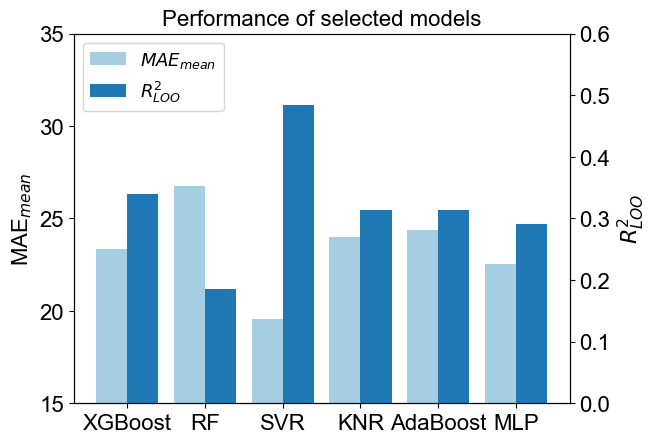

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.ticker as ticker

data_pic = pd.read_csv('model_pic.csv')
# print(data_pic)

data_pic = data_pic[data_pic['Model'].isin(['AdaBoost', 'RF',  'XGBoost','SVR','MLP','KNR'])]
x = data_pic['Model']
y1 = data_pic['MAE_mean']
y2 = data_pic['R2_LOO']

x_pos = np.arange(len(x))
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(8, 8))

# Create a new figure
fig, ax1 = plt.subplots()

# Get paired colors
colors = sns.color_palette("Paired")

# Plot the first set of data as bars
bar1 = ax1.bar(x_pos - 0.2, y1, 0.4, label='MAE_mean', color=colors[0])

# Set y-axis label
ax1.set_ylabel(r'MAE$_{mean}$',fontsize = 16)
ax1.set_ylim(15, 35)
# ax1.set_ylim(15, 35)
# Set ax1 y-axis ticks with interval of 5
ax1.set_yticks(np.arange(15, 36, 5))
# Set ax1 y-axis tick labels format as integers
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax1.tick_params(axis='y',labelsize=16)
ax1.tick_params(axis='y',labelsize=16)
# ax1.legend(loc='upper right',bbox_to_anchor=(1, 0.9))
labels = [r'$MAE_{mean}$', r'$R^2_{LOO}$']

# Create a second y-axis
ax2 = ax1.twinx()
# print(y2)

min_y2 = 0
max_y2 = 0.6
print(min_y2)
# Set the range of the second y-axis, starting from the minimum value

# Plot the second set of data as bars
bar2 = ax2.bar(x_pos + 0.2, y2,0.4, label=r'$R^2_{LOO}$', color=colors[1],bottom=0)
ax1.legend([bar1, bar2], labels, loc='upper left',fontsize = 13)

# Set y-axis label
ax2.set_ylabel(r'$R^2_{LOO}$',fontsize = 16)
# ax2.legend(loc='upper right',bbox_to_anchor=(1, 1))
ax2.set_ylim(min_y2, max_y2)
ax2.tick_params(axis='y',labelsize=16)
# Get the minimum and maximum values of y2 data

# Set x-axis labels
ax1.set_xticks(x_pos)
ax1.set_xticklabels(x,fontsize = 16)  # Add rotated labels to improve display

# Set chart title
plt.title("Performance of selected models",fontsize = 16)

# Display the figure
# plt.show()
plt.savefig('model_pic_filtered.png',dpi=600,format='png',bbox_inches='tight')
plt.savefig('model_pic_filtered.tif',dpi=600,format='tif',bbox_inches='tight')
# plt.savefig('model_pic_filtered.eps',format='eps',bbox_inches='tight')

100%|██████████| 18/18 [00:00<00:00, 148.92it/s]


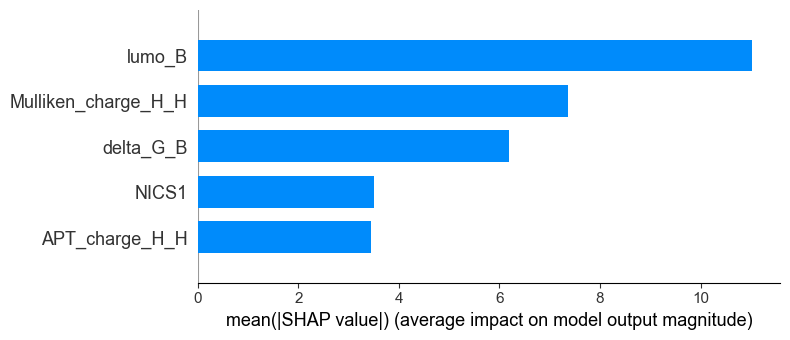

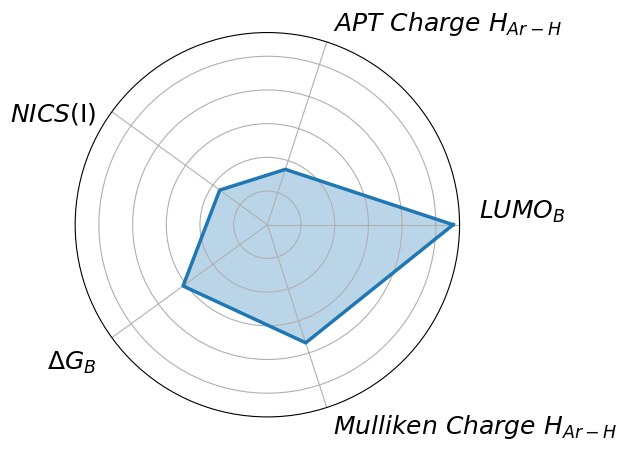

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import pandas as pd
import shap
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = pd.read_csv('data_round2.csv')
model1 = SVR(C= 63.91726535154404, epsilon= 0.01666549751396613, gamma= 5.275057481551831)
data1 = data[['Mulliken_charge_H_H', 'APT_charge_H_H', 'NICS1', 'delta_G_B', 'lumo_B','yield']]

features = data1.select_dtypes(include=[np.number]).columns
X = data1[features].drop('yield', axis=1)
y = data1['yield']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler(feature_range=(0, 100))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()
model1.fit(X_train_scaled, y_train_scaled)
# Analyze SVR model using SHAP
explainer = shap.KernelExplainer(model1.predict, X_train_scaled)

shap_values = explainer.shap_values(X_test_scaled)
# Plot bar chart of SHAP analysis
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Calculate mean_abs_shap_values
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Radar chart
# Define feature names in LaTeX format
# model = SVR(C= 63.91726535154404, epsilon= 0.01666549751396613, gamma= 5.275057481551831)
# data1 = data[['Mulliken_charge_H_H', 'APT_charge_H_H', 'NICS1', 'delta_G_B', 'lumo_B','yield']]
latex_feature_names = [
    r'$Mulliken \ Charge \ H_{Ar-H}$',
    r'$APT \ Charge \ H_{Ar-H}$',
    r'$NICS(Ⅰ)$',
    r'$\Delta G_{B}$',
    r'$LUMO_{B}$'
]

# change order
# Define new order (assuming this is the desired new order)
new_order = [4,1,2,3,0]  # e.g., delta_G_B, lumo_B, Mulliken, APT, NICS1

# Reorder latex_feature_names
latex_feature_names = [latex_feature_names[i] for i in new_order]

# Reorder mean_abs_shap_values
mean_abs_shap_values = np.array([mean_abs_shap_values[i] for i in new_order])



# Set radar chart parameters
N = len(latex_feature_names)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Close the radar chart

# Initialize radar chart, reduce figure size
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Prepare data
values = mean_abs_shap_values.tolist()
values += values[:1]  # Close radar chart data

# Draw radar chart
ax.plot(angles, values, linewidth=2.5, linestyle='solid', label='Feature Importance')
ax.fill(angles, values, alpha=0.3)

# Set radar chart labels, increase font size
ax.set_xticks(angles[:-1])
labels = ax.set_xticklabels(latex_feature_names, fontsize=18)

# Adjust label positions
for i, label in enumerate(labels):
    angle = angles[i]
    # Adjust label alignment based on angle
    if 0 <= angle < pi/2 or 3*pi/2 < angle <= 2*pi:
        label.set_horizontalalignment('left')
    else:
        label.set_horizontalalignment('right')
    
    # Fine-tune vertical alignment
    if pi/4 <= angle < 3*pi/4 or 5*pi/4 <= angle < 7*pi/4:
        label.set_verticalalignment('center')
    elif 3*pi/4 <= angle < 5*pi/4:
        label.set_verticalalignment('top')
    else:
        label.set_verticalalignment('bottom')

# Hide radial ticks
ax.set_yticklabels([])

# Hide radial ticks
ax.set_yticklabels([])

plt.tight_layout()

plt.savefig('radar_chart_dpi600.png', dpi=600, format='png', bbox_inches='tight')

# save svg
plt.savefig('radar_chart_dpi600.svg', format='svg', bbox_inches='tight')
# save pdf
plt.savefig('radar_chart_dpi600.pdf', format='pdf', bbox_inches='tight')
plt.show()

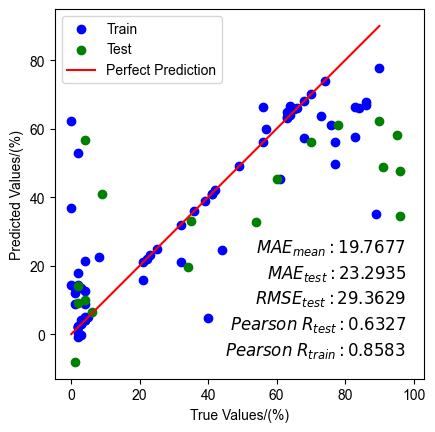

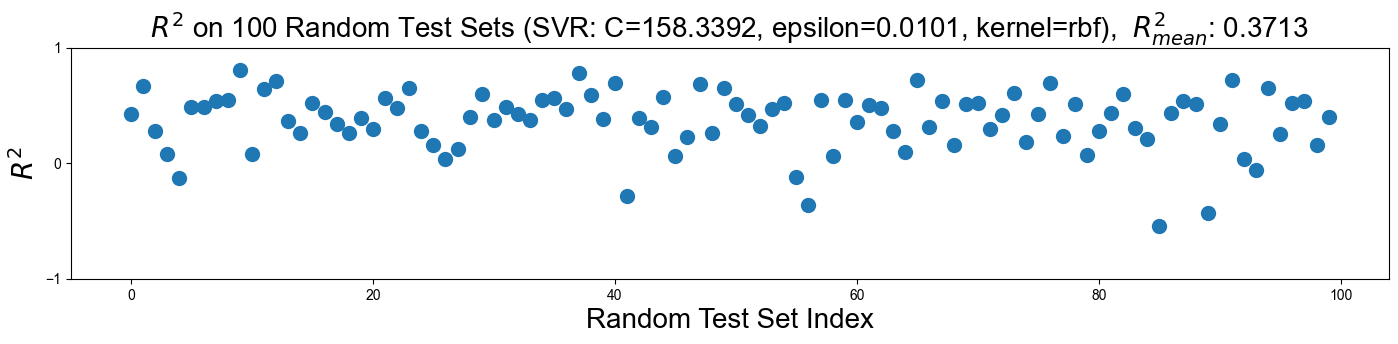

In [4]:
# plot r2 on 100 random samples for top 5 best SVR(after feature filter)
def plot_r2_on_100_random_samples(data, model, model_name):
    import joblib
    import os

    # 创建输出文件夹
    output_dir = 'output'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    features = data.select_dtypes(include=[np.number]).columns
    X = data[features].drop('yield', axis=1)
    y = data['yield']
    scaler = StandardScaler()

    mae_test_list = []
    for i in range(100):
        random_state = i
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
        model.fit(scaler.fit_transform(X_train), y_train)
        y_pred_test = model.predict(scaler.transform(X_test))
        mae_test = mean_absolute_error(y_test, y_pred_test)
        mae_test_list.append(mae_test)
    mae_mean = np.mean(mae_test_list)

    y_pred_train = model.predict(scaler.transform(X_train))
    y_pred_test = model.predict(scaler.transform(X_test))

    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    r2_train = r2_score(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)

    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test = r2_score(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    # 设置纵横比

    plt.gca().set_aspect('equal', adjustable='box')
    plt.scatter(y_train, y_pred_train, color='blue', label='Train')
    plt.scatter(y_test, y_pred_test, color='green', label='Test')
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', label='Perfect Prediction')
    plt.xlabel('True Values/(%)')
    plt.ylabel('Predicted Values/(%)')
    plt.axis('square')
    # plt.title(f'Actual vs Predicted Values for SVR')
    plt.legend(loc='upper left')

    plt.text(0.95, 0.05, fr"$Pearson \; R_{{train}}: {np.sqrt(r2_train):.4f}$", fontsize=12, ha='right', va='bottom', fontname='Arial', transform=plt.gca().transAxes)
    plt.text(0.95, 0.19, fr"$RMSE_{{test}}: {rmse_test:.4f}$", fontsize=12, ha='right', va='bottom', fontname='Arial', transform=plt.gca().transAxes)
    plt.text(0.95, 0.12, fr"$Pearson \; R_{{test}}: {np.sqrt(r2_test):.4f}$", fontsize=12, ha='right', va='bottom', fontname='Arial', transform=plt.gca().transAxes)        
    plt.text(0.95, 0.26, fr"$MAE_{{test}}: {mae_test:.4f}$", fontsize=12, ha='right', va='bottom', fontname='Arial', transform=plt.gca().transAxes)
    plt.text(0.95, 0.33, fr'$MAE_{{mean}}: {mae_mean:.4f}$', fontsize=12, ha='right', va='bottom', fontname='Arial', transform=plt.gca().transAxes)
    plt.savefig(f'output/{model_name}_scatter.tif', dpi=600)
    plt.savefig(f'output/{model_name}_scatter.png', dpi=600)
    plt.show()

    r2_test_list = []
    mae_test_list = []
    for i in range(100):
        random_state = i
        X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=random_state)
        model.fit(scaler.fit_transform(X_train_1), y_train_1)
        y_pred_test_1 = model.predict(scaler.transform(X_test_1))
        r2_test_1 = r2_score(y_test_1, y_pred_test_1)
        mae_test_1 = mean_absolute_error(y_test_1, y_pred_test_1)
        mae_test_list.append(mae_test_1)
        r2_test_list.append(r2_test_1)
    plt.figure(figsize=(17, 3))
    plt.scatter(range(100), r2_test_list, s=100)
    plt.ylim(-1, 1)
    plt.yticks([-1, 0, 1])
    plt.xlabel('Random Test Set Index', fontsize=20, fontname='Arial')
    plt.ylabel(fr'$R^2$', fontsize=20, fontname='Arial')
    plt.title(fr'$R^2$ on 100 Random Test Sets (SVR: C={float(model.get_params()["C"]):.4f}, epsilon={float(model.get_params()["epsilon"]):.4f}, kernel={(model.get_params()["kernel"])}),  $R^2_{{mean}}$: {float(np.mean(r2_test_list)):.4f}', fontsize=20, fontname='Arial')
    plt.savefig(f'output/{model_name}_r2.tif', dpi=600)
    plt.savefig(f'output/{model_name}_r2.png', dpi=600)
    plt.show()

    # 保存模型
    joblib.dump(model, f'output/{model_name}.pkl')

# example
model1 = SVR(C= 158.33920184621587, epsilon= 0.010066299611558627, kernel= 'rbf')
# model2 = SVR(C= 199.387300053416, epsilon= 3.2145706038796624, kernel= 'rbf')
# model3 = SVR(C= 123.87569875219091, epsilon= 0.010112370277886976, kernel= 'rbf')
# model4 = SVR(C= 135.8498350249319, epsilon= 0.06273903641440354, kernel= 'rbf')
# model5 = SVR(C= 144.30093680582306, epsilon= 0.015788838455621842, kernel= 'rbf')
data1 = data[['delta_G_B', 'dipole_H', 'homo_B', 'Mulliken_charge_H_H', 'NPA_charge_H_H','yield']]
# data2 = data[['delta_G_B', 'Mulliken_charge_H_H', 'NPA_charge_H_H','yield']]
# data3 = data[['delta_G_B', 'dipole_H', 'homo_B', 'Mulliken_charge_H_H', 'NPA_charge_H_H', 'Mulliken_charge_alpha_1','yield']]
# data4 = data[['delta_G_B', 'dipole_H', 'homo_B', 'APT_charge_C_H', 'Mulliken_charge_H_H', 'NPA_charge_H_H','yield']]
# data5 = data[['delta_G_B', 'dipole_H', 'homo_B', 'Mulliken_charge_H_H', 'Mulliken_charge_C_H', 'NPA_charge_H_H','yield']]
plot_r2_on_100_random_samples(data1, model1, 'model1')
# plot_r2_on_100_random_samples(data2, model2, 'model2')
# plot_r2_on_100_random_samples(data3, model3, 'model3')
# plot_r2_on_100_random_samples(data4, model4, 'model4')
# plot_r2_on_100_random_samples(data5, model5, 'model5')